## Import librairies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
from datetime import datetime


## Import data

In [91]:
# Charger le CSV
csv_path = '_classes2.csv'
df = pd.read_csv(csv_path)

# Dossier contenant les images
image_path = r"C:\Users\malam\Documents\2 - ECOLE\HENALLUX VIRTON\M1 - INGENIEUR INDUSTRIEL AUTOMATION\13 - SYSTEMES INTELLIGENTS\Self-Driving Cars.v6-version-4-prescan-416x416.multiclass\train"
image_dir = Path(image_path)

# Vérifier les colonnes disponibles (les labels)
label_columns = df.columns.tolist()[1:]  # On exclut 'filename'

print("Colonnes de label :", label_columns)

# Vérifie que le fichier existe
df['filepath'] = df['filename'].apply(lambda x: str(image_dir / x))
df = df[df['filepath'].apply(os.path.exists)]  # Garde uniquement les fichiers valides


Colonnes de label : [' Green Light', ' Red Light', ' Speed Limit 10', ' Speed Limit 100', ' Speed Limit 110', ' Speed Limit 120', ' Speed Limit 20', ' Speed Limit 30', ' Speed Limit 40', ' Speed Limit 50', ' Speed Limit 60', ' Speed Limit 70', ' Speed Limit 80', ' Speed Limit 90', ' Stop']


## Split into train and test

In [92]:
# Paramètres
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Fonction pour lire et redimensionner une image
def load_and_preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img / 255.0  # Normalisation

# Appliquer à tout le dataset
X = np.array([load_and_preprocess_image(path) for path in df['filepath']])
y = df[label_columns].values.astype(np.float32)  # Multilabel binaires (0/1)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paramètres d'augmentation
ROTATION_RANGE = 15
ZOOM_RANGE = 0.05
WIDTH_SHIFT = 0.05
HEIGHT_SHIFT = 0.05
HORIZONTAL_FLIP = True

# Augmentation uniquement sur le train
train_datagen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE,
    zoom_range=ZOOM_RANGE,
    width_shift_range=WIDTH_SHIFT,
    height_shift_range=HEIGHT_SHIFT,
    horizontal_flip=HORIZONTAL_FLIP
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
test_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=BATCH_SIZE)


## Build the model

In [93]:
model = models.Sequential([
    # Couche d'entrée : spécifie la forme des images (128x128 pixels, 3 canaux RGB)
    layers.Input(shape=(*IMG_SIZE, 3)),
    
    # Première couche de convolution :
    # - 32 filtres de taille 3x3
    # - Fonction d'activation ReLU
    layers.Conv2D(16, (3, 3), activation='relu'),
    # Réduction de dimension par max pooling 2x2
    layers.MaxPooling2D(2, 2),
    
    # Deuxième couche de convolution :
    # - 64 filtres (plus de filtres pour détecter plus de caractéristiques)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Troisième couche de convolution :
    # - 128 filtres pour des caractéristiques plus complexes
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Aplatissement des données pour les couches denses
    layers.Flatten(),
    # Couche dense avec 128 neurones 
    layers.Dense(64, activation='relu'),
    # Dropout de 50% pour éviter le surapprentissage
    layers.Dropout(0.5),
    
    # Couche de sortie :
    # - Autant de neurones que de classes (len(label_columns))
    # - Activation sigmoid pour la classification multi-label
    layers.Dense(len(label_columns), activation='sigmoid')
])
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 827,439 (3.16 MB)

 Trainable params: 827,439 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [94]:
# Compilation et entraînement du modèle
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Pour classification multi-label
    metrics=['accuracy']
)



# Create a timestamped folder for this run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_dir = f'model_checkpoints_{timestamp}'
os.makedirs(checkpoint_dir, exist_ok=True)

callbacks = [
    # EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(
        os.path.join(checkpoint_dir, 'best_model.h5'), 
        save_best_only=True
    )
]

EPOCHS = 50  # Nombre d'epochs pour l'entraînement initial

# Augmentation du nombre d'epochs à 15 pour permettre un meilleur apprentissage
# - Plus d'epochs = plus d'opportunités pour le modèle d'apprendre
# - La validation_data permet de suivre le surapprentissage
history = model.fit(
    train_generator,
    epochs=EPOCHS, 
    validation_data=test_generator,
    callbacks=callbacks
)


c:\Users\malam\Documents\10 - VENV\SI_Env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0758 - loss: 0.4080

87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.0760 - loss: 0.4073 - val_accuracy: 0.2997 - val_loss: 0.2398
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1749 - loss: 0.2759

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.1750 - loss: 0.2758 - val_accuracy: 0.3386 - val_loss: 0.2221
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.2003 - loss: 0.2576

87/87 ━━━━━━━━━━━━━━━━━━━━ 30s 353ms/step - accuracy: 0.2006 - loss: 0.2576 - val_accuracy: 0.3242 - val_loss: 0.2138
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.2640 - loss: 0.2456

87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 432ms/step - accuracy: 0.2639 - loss: 0.2455 - val_accuracy: 0.3343 - val_loss: 0.2063
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2743 - loss: 0.2346

87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.2744 - loss: 0.2346 - val_accuracy: 0.3501 - val_loss: 0.2056
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - accuracy: 0.2743 - loss: 0.2341 - val_accuracy: 0.3401 - val_loss: 0.2057
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.2864 - loss: 0.2301

87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.2864 - loss: 0.2301 - val_accuracy: 0.3732 - val_loss: 0.2016
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.3142 - loss: 0.2220

87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 458ms/step - accuracy: 0.3141 - loss: 0.2221 - val_accuracy: 0.4078 - val_loss: 0.1974
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - accuracy: 0.3116 - loss: 0.2231 - val_accuracy: 0.4078 - val_loss: 0.1979
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3269 - loss: 0.2158

87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - accuracy: 0.3268 - loss: 0.2158 - val_accuracy: 0.4121 - val_loss: 0.1925
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.3364 - loss: 0.2143

87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 440ms/step - accuracy: 0.3364 - loss: 0.2143 - val_accuracy: 0.4179 - val_loss: 0.1908
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.3616 - loss: 0.2100

87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.3615 - loss: 0.2100 - val_accuracy: 0.4020 - val_loss: 0.1864
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - accuracy: 0.3618 - loss: 0.2058 - val_accuracy: 0.3905 - val_loss: 0.1918
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.3684 - loss: 0.2063

87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 452ms/step - accuracy: 0.3686 - loss: 0.2063 - val_accuracy: 0.4280 - val_loss: 0.1832
Epoch 15/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.3894 - loss: 0.2012 - val_accuracy: 0.4625 - val_loss: 0.1838
Epoch 16/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.3843 - loss: 0.2008 - val_accuracy: 0.4121 - val_loss: 0.1867
Epoch 17/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3785 - loss: 0.1979

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.3784 - loss: 0.1979 - val_accuracy: 0.4597 - val_loss: 0.1789
Epoch 18/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4048 - loss: 0.1934

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.4047 - loss: 0.1934 - val_accuracy: 0.4755 - val_loss: 0.1788
Epoch 19/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.4211 - loss: 0.1923 - val_accuracy: 0.4337 - val_loss: 0.1790
Epoch 20/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 0.4036 - loss: 0.1953 - val_accuracy: 0.4741 - val_loss: 0.1816
Epoch 21/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4126 - loss: 0.1936

87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.4126 - loss: 0.1935 - val_accuracy: 0.4899 - val_loss: 0.1724
Epoch 22/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.3965 - loss: 0.1938 - val_accuracy: 0.4712 - val_loss: 0.1740
Epoch 23/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.4289 - loss: 0.1900 - val_accuracy: 0.4784 - val_loss: 0.1745
Epoch 24/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.4242 - loss: 0.1856 - val_accuracy: 0.4870 - val_loss: 0.1752
Epoch 25/50
86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4461 - loss: 0.1845

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.4461 - loss: 0.1845 - val_accuracy: 0.5029 - val_loss: 0.1711
Epoch 26/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.4238 - loss: 0.1836 - val_accuracy: 0.5115 - val_loss: 0.1718
Epoch 27/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.4608 - loss: 0.1781 - val_accuracy: 0.5101 - val_loss: 0.1733
Epoch 28/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4581 - loss: 0.1796

87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.4581 - loss: 0.1796 - val_accuracy: 0.5173 - val_loss: 0.1680
Epoch 29/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4717 - loss: 0.1784

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.4715 - loss: 0.1784 - val_accuracy: 0.5346 - val_loss: 0.1672
Epoch 30/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4929 - loss: 0.1728

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.4928 - loss: 0.1728 - val_accuracy: 0.5259 - val_loss: 0.1656
Epoch 31/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.4666 - loss: 0.1776 - val_accuracy: 0.5432 - val_loss: 0.1671
Epoch 32/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4489 - loss: 0.1777

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.4491 - loss: 0.1777 - val_accuracy: 0.5375 - val_loss: 0.1638
Epoch 33/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4871 - loss: 0.1680

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.4871 - loss: 0.1681 - val_accuracy: 0.5836 - val_loss: 0.1617
Epoch 34/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.4903 - loss: 0.1672 - val_accuracy: 0.5490 - val_loss: 0.1728
Epoch 35/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.5020 - loss: 0.1665 - val_accuracy: 0.5461 - val_loss: 0.1717
Epoch 36/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.5022 - loss: 0.1681 - val_accuracy: 0.5605 - val_loss: 0.1654
Epoch 37/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4897 - loss: 0.1673

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.4899 - loss: 0.1673 - val_accuracy: 0.5735 - val_loss: 0.1608
Epoch 38/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5370 - loss: 0.1617

87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.5368 - loss: 0.1617 - val_accuracy: 0.5591 - val_loss: 0.1573
Epoch 39/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.5296 - loss: 0.1613 - val_accuracy: 0.5764 - val_loss: 0.1595
Epoch 40/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.5179 - loss: 0.1600 - val_accuracy: 0.5764 - val_loss: 0.1605
Epoch 41/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.5284 - loss: 0.1583 - val_accuracy: 0.5706 - val_loss: 0.1575
Epoch 42/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.5553 - loss: 0.1533 - val_accuracy: 0.5850 - val_loss: 0.1579
Epoch 43/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5683 - loss: 0.1531

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.5681 - loss: 0.1532 - val_accuracy: 0.5749 - val_loss: 0.1552
Epoch 44/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5306 - loss: 0.1602

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.5307 - loss: 0.1601 - val_accuracy: 0.5807 - val_loss: 0.1544
Epoch 45/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5439 - loss: 0.1546

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.5438 - loss: 0.1546 - val_accuracy: 0.5908 - val_loss: 0.1504
Epoch 46/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5623 - loss: 0.1512 - val_accuracy: 0.5720 - val_loss: 0.1600
Epoch 47/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.5609 - loss: 0.1507 - val_accuracy: 0.5821 - val_loss: 0.1518
Epoch 48/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5482 - loss: 0.1495

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.5483 - loss: 0.1496 - val_accuracy: 0.5720 - val_loss: 0.1471
Epoch 49/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.5687 - loss: 0.1511 - val_accuracy: 0.5951 - val_loss: 0.1529
Epoch 50/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 0.5628 - loss: 0.1506 - val_accuracy: 0.5908 - val_loss: 0.1528


## Evaluation

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5606 - loss: 0.1645
Test Loss: 0.1528, Test Accuracy: 0.5908


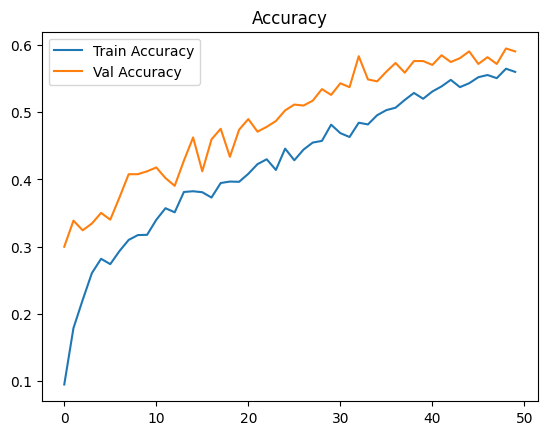

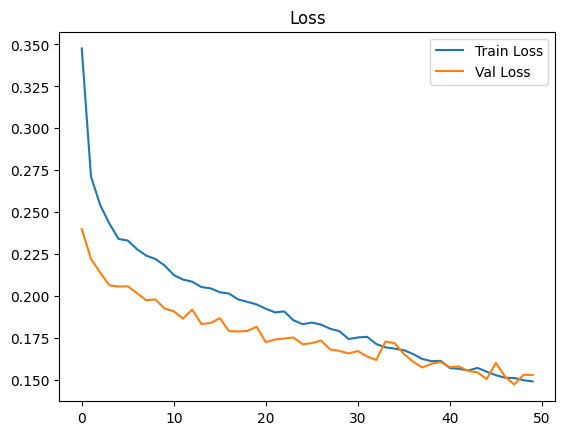

In [95]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Affichage des courbes
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Classification Report:
                  precision    recall  f1-score   support

     Green Light     0.7059    0.4800    0.5714        75
       Red Light     0.7083    0.2179    0.3333        78
  Speed Limit 10     0.0000    0.0000    0.0000         1
 Speed Limit 100     0.7500    0.1698    0.2769        53
 Speed Limit 110     0.0000    0.0000    0.0000        23
 Speed Limit 120     1.0000    0.3654    0.5352        52
  Speed Limit 20     1.0000    0.9310    0.9643        58
  Speed Limit 30     0.7500    0.0952    0.1690        63
  Speed Limit 40     0.7143    0.0926    0.1639        54
  Speed Limit 50     0.8333    0.3191    0.4615        47
  Speed Limit 60     0.9545    0.4200    0.5833        50
  Speed Limit 70     0.9000    0.4426    0.5934        61
  Speed Limit 80     0.5500    0.1964    0.2895        56
  Speed Limit 90     0.0000    0.0000    0.0000        48
            Stop     1.0000    0.8235    0.9032        68

       

c:\Users\malam\Documents\10 - VENV\SI_Env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\malam\Documents\10 - VENV\SI_Env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\malam\Documents\10 - VENV\SI_Env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

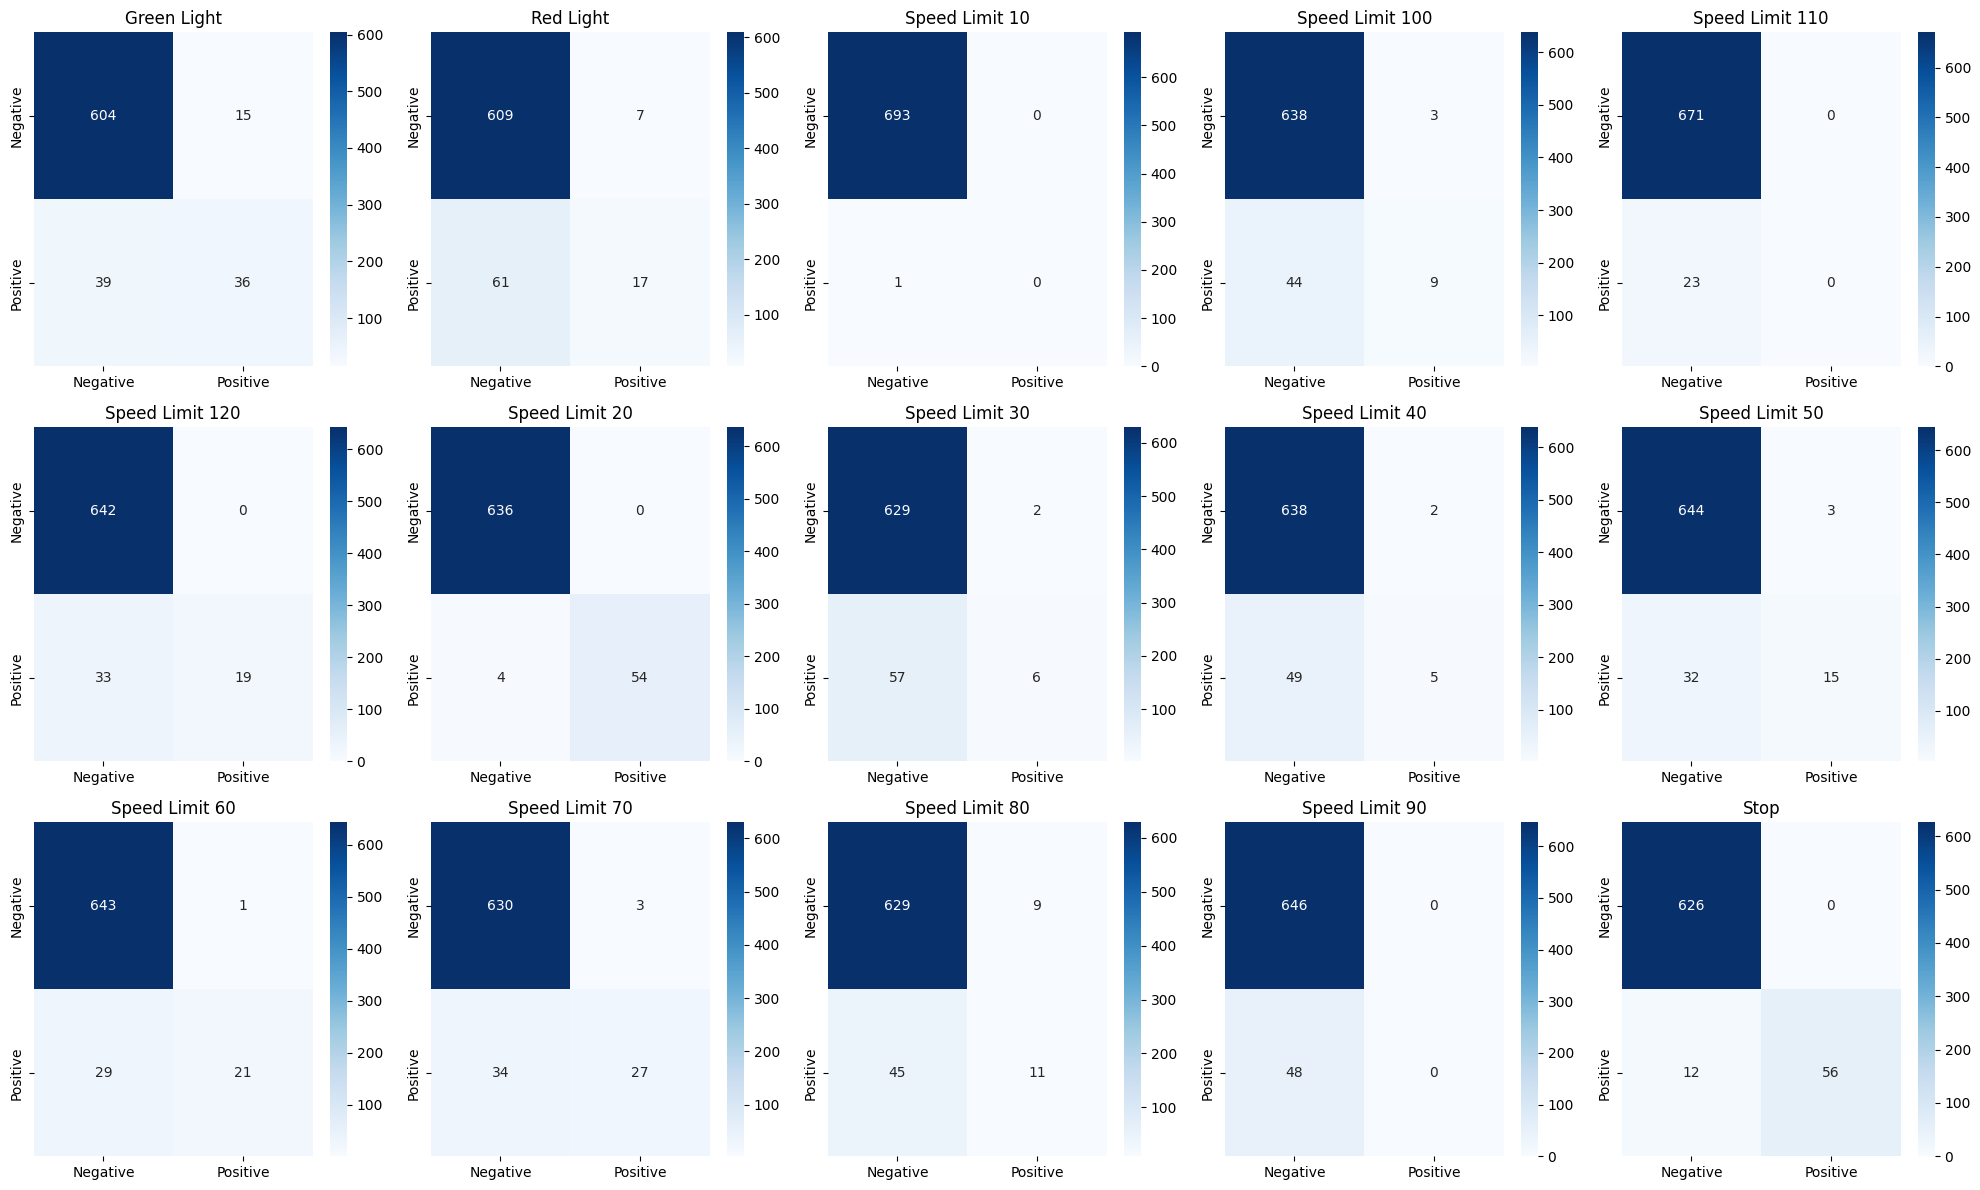


Overall Exact Match Accuracy: 0.3689


In [96]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
y_sigmoid = model.predict(X_test)
# Convert probabilities to binary predictions using 0.5 as threshold
y_pred = (y_sigmoid > 0.5).astype(int)

# Calculate and print classification report for multi-label
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_columns, digits=4))

# Calculate confusion matrix for each label
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Plot confusion matrix for each label
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.ravel()

for idx, (matrix, label) in enumerate(zip(conf_matrices, label_columns)):
    sns.heatmap(matrix, 
                annot=True, 
                fmt='d',
                cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[idx])
    axes[idx].set_title(f'{label.strip()}')

plt.tight_layout()
plt.show()

# Calculate overall accuracy
accuracy = np.mean(np.all(y_pred == y_test, axis=1))
print(f"\nOverall Exact Match Accuracy: {accuracy:.4f}")

## Save and load the model and try with new data

In [ ]:
import pandas as pd
from datetime import datetime
import os

# Prepare data to save
model_data = {
    'Date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Image_Size': f"{IMG_SIZE[0]}x{IMG_SIZE[1]}",
    'Batch_Size': BATCH_SIZE,
    'Epochs': EPOCHS,
    'Final_Accuracy': accuracy,
    'Final_Loss': loss,
    'Model_Architecture': str(model.summary()),
    'Data_Augmentation': {
        'rotation_range': ROTATION_RANGE,
        'zoom_range': ZOOM_RANGE,
        'width_shift_range': WIDTH_SHIFT,
        'height_shift_range': HEIGHT_SHIFT,
        'horizontal_flip': HORIZONTAL_FLIP
    }
}

# Convert to DataFrame
df_new = pd.DataFrame([model_data])

# Check if file exists
csv_filename = 'Model_parameters.csv'
if os.path.exists(csv_filename):
    # Append to existing file
    df_new.to_csv(csv_filename, mode='a', header=False, index=False)
else:
    # Create new file
    df_new.to_csv(csv_filename, index=False)

print(f"Model parameters saved to {csv_filename}")

In [ ]:
def save_model_with_timestamp(model, base_folder="model_saves_Panneaux_Scan"):
    # Create folder if it doesn't exist
    os.makedirs(base_folder, exist_ok=True)
    
    # Generate filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"sign_classifier_{timestamp}.h5"
    
    # Full path
    model_path = os.path.join(base_folder, model_filename)
    
    # Save the model
    model.save(model_path)
    
    print(f"Model saved to {model_path}")

# Use the function
save_model_with_timestamp(model)


## Save the model bis